# Content
- Import packages
- Overview of the dataset
- EDA (countplot for numerical features, correlation matrix)
- Text preprocessing (convert text to lower-case, remove URLs, usernames, hashtags, punctuation, repeated characters (helloooooooo into hello), stopwords)
- Missing Data and imputation (favorite_count, in_reply_status_to)
- Feature engineering for fun (emojis list , counturl and url columns)

## Import Packages

In [1]:
import pandas as pd
import re 
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
import pickle
# import en_core_web_sm
import os
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
import emoji
import regex
import string
from urlextract import URLExtract
from langdetect import detect

D:\deniz\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
import functions
exec(open('./functions.py').read())

C:\Anaconda\envs\uni\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\home\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
... OK (Got response in 0.44 seconds)
Writing emoji data to C:\Users\home\.demoji\codes.json ...
... OK
[nltk_data] Downloading package stopwords to
[nltk_data]     

In [4]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\deniz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Overview of the dataset

In [22]:
df = pickle.load(open('data_n_models/one_cleaned_df.pkl', "rb"))
# select german lang
de_df = df[df.language == 'de']
de_df.head()

,user_id,user_statuses,name,tweet,retweets,location,created,followers,is_user_verified,favorite_count,in_reply_to_status_id,keyword,language
0,1079317443523297280,12303,Boulder667,@spdde @LadyBitchRay1 @spdbt @amazonDE @Zaland...,0,"Liverpool, England",07-Mar-2021,116,False,0.0,1.368470e+18,zalando,de
1,1079317443523297280,12303,Boulder667,"@spdde @LadyBitchRay1 Viel Spaß, damit eine Wa...",0,"Liverpool, England",07-Mar-2021,116,False,1.0,1.368148e+18,zalando,de
2,1193535074660171776,693,FabIan68286784,@missbellalugosi @Zalando Kleiner Einwand von ...,0,,06-Mar-2021,57,False,0.0,1.368196e+18,zalando,de
3,1318999115313876996,1554,mantis_spam,@missbellalugosi @Zalando Etwas aus PU als Jog...,0,,06-Mar-2021,1273,False,2.0,1.368196e+18,zalando,de
4,310342425,11476,AndyBaldauf,@dicecco @Zalando aber erst wenn sie wieder dü...,0,Thurgau | St. Gallen | Zürich,06-Mar-2021,1848,False,0.0,1.368146e+18,zalando,de


# Filter out companies` tweets
There are some tweets that posted by companies themselves. In order to not take them into account we have to filter them out

In [23]:
#collect all the names related to companies as well as bots and scripts
names = []
pat = r'(zalando|asos|boohoo|MidwestWeather3|Proxy4Sure)'
for name in de_df.name.unique():
    match = re.findall(pat, name, re.IGNORECASE) 
    if len(match) > 0:
        names.append(name)
names

['Zalando',
 'Zalando_Press',
 'ZalandoS',
 'ASOS_Careers',
 'ZalandoTech',
 'BOOHOO_ABI',
 'boohoo',
 'ASOS',
 'Boohoo_Cracker_']

In [24]:
#check how much data left
print(de_df.shape)
de_df.drop(de_df[de_df.name.isin(names)].index).shape

(10222, 13)


(7092, 13)

In [25]:
#filter out the dataframe
de_df = de_df.drop(de_df[de_df.name.isin(names)].index)

# Duplicates
Theoretically, people can post the same tweets multiple times and retweet others tweets (so that there is the same tweet text). In order to get rid of too much duplicates and to keep retweets, we keep only tweets with unique combination of text, date and account name

In [26]:
#check for tweets duplicates
de_df.tweet.value_counts()

@highgrounddd einfach asos und zalando halt                                                                                                                                                                                                                                       11
BestSecret-Gruppe: Ehemaliger Zalando-Manager wird alleiniger CEO https://t.co/PCYTz9JJYH                                                                                                                                                                                         11
$ZAL #ZALANDO @Zalando - Täglich: Der neutrale kurzfristige Trend zeigt eine Abflachung des zugrunde liegenden leichten bullischen Trends bei {Produktname}. Unter diesen Bedingungen... https://t.co/rrIZPCrber                                                                  11
ok @Zalando, Telefon Hotline weiß von nichts wegen Neukunden/Newsletter Gutschein, aber auch schlecht wenn man kaum Deutsch versteht 🙄 musste alles dreimal wiederholen! 

In [27]:
#filtering out tweets duplicates
de_df = de_df.drop_duplicates(subset=['tweet','name','created'])
de_df.shape

(2709, 13)

# How many times companies are discussed?
Among 3 companies in german speaking audience zalando is the most discussed company

In [28]:
de_df.keyword.value_counts()

zalando    2029
asos        603
boohoo       75
bohoo         2
Name: keyword, dtype: int64

<AxesSubplot:xlabel='keyword', ylabel='count'>

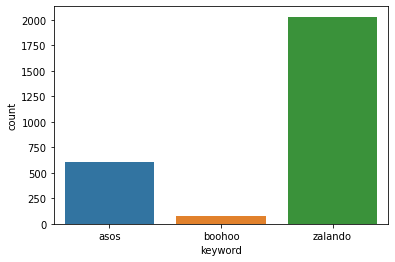

In [31]:
sns.countplot(x="keyword", data=de_df, order=['asos', 'boohoo', 'zalando'])

# Save filtered dataset
tweets should be cleaned still

In [36]:
pickle.dump(de_df, open(r'.\data_n_models\de_df_filtered.pkl', 'wb'))

# Next steps

clean tweets complete and for vader

derive vader sentiment

save pickle as de_df_labelled

In [30]:
# so few rows??
print(f"{de_df.shape[0]} rows and {de_df.shape[1]} columns")

2709 rows and 13 columns


In [7]:
de_df.describe()

,user_id,user_statuses,retweets,followers,favorite_count,in_reply_to_status_id
count,1.060500e+04,1.060500e+04,10605.000000,1.060500e+04,10222.000000,4.234000e+03
mean,5.598861e+17,4.638095e+04,0.307214,1.087439e+04,4.367443,1.373391e+18
std,5.943789e+17,1.345854e+05,3.129439,1.057279e+05,33.673530,4.425580e+15
min,1.030701e+06,1.000000e+00,0.000000,0.000000e+00,0.000000,1.352990e+18
25%,2.804892e+08,1.550000e+03,0.000000,1.210000e+02,0.000000,1.369981e+18
50%,4.423529e+09,7.539000e+03,0.000000,4.140000e+02,1.000000,1.373484e+18
75%,1.221430e+18,2.630700e+04,0.000000,1.413000e+03,3.000000,1.376506e+18
max,1.383458e+18,1.398951e+06,191.000000,2.986347e+06,1485.000000,1.384093e+18


# EDA

In [13]:
# be aware could take some time and memory!
# pp = ProfileReport(de_df)
# pp.to_file(output_file='Zalando_de.html')

retweets:  0      9491
1       630
2       242
3        81
4        43
5        29
6        19
7        17
13       11
8         8
9         4
15        4
34        4
10        4
16        2
17        2
33        2
191       2
19        2
55        2
37        2
20        1
36        1
53        1
27        1
Name: retweets, dtype: int64


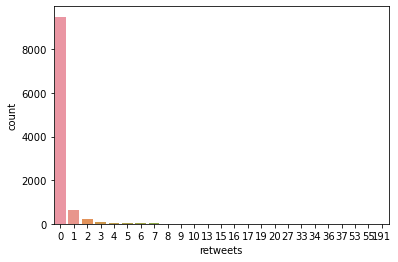

In [14]:
ax = sns.countplot(x="retweets", data=de_df)
print("retweets: ", de_df.retweets.value_counts())

followers:  0          154
488        107
3           78
139         71
5           66
          ... 
2578         1
531          1
806          1
2984498      1
2047         1
Name: followers, Length: 2461, dtype: int64


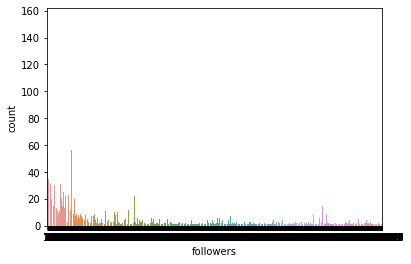

In [15]:
ax = sns.countplot(x="followers", data=de_df)
print("followers: ", de_df.followers.value_counts())

favorite_count:  0.0       4108
1.0       2406
2.0       1088
3.0        648
4.0        388
          ... 
121.0        1
886.0        1
1387.0       1
63.0         1
1485.0       1
Name: favorite_count, Length: 95, dtype: int64


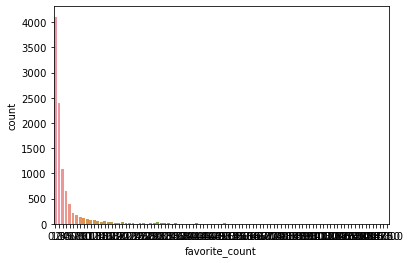

In [16]:
ax = sns.countplot(x="favorite_count", data=de_df)
print("favorite_count: ", de_df.favorite_count.value_counts())

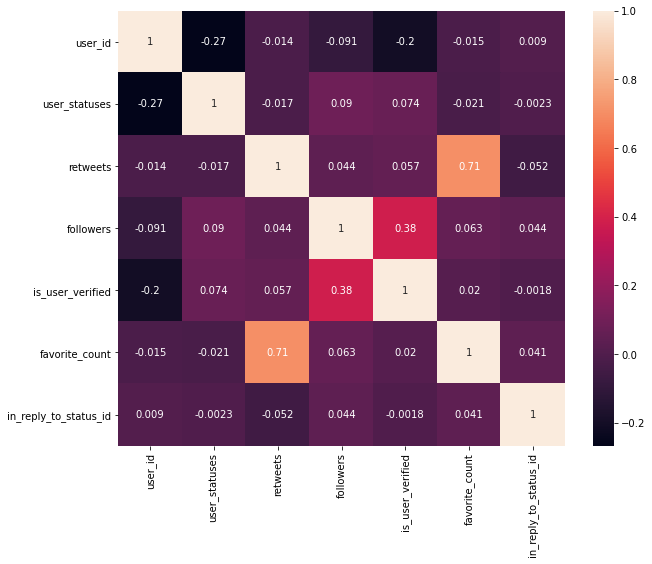

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(de_df.corr(), annot=True)

Rule of thumb: 0 = no linear correlation
0.3 = weak positive linear correlation
0.5 = moderately strong positive linear relationship
0.8 = strong positive linear relationship
-0.3 = weak negative linear relationship
-0.5 = moderately strong negative linear relationship
-0.8 = strong negative linear relationship

Moderate strong positive linear relationship (0.71) between retweets and favorite count. This means if the retweets are increasing also the favorite counts increases too. Moderate weak positive linear correlation (0.38) between is_user_verifies and followers.



# Text Preprocessing
- Missing Data and imputation
- Convert text to lower-case
- remove URLs
- remove usernames
- remove hashtags
- remove punctuation
- remove repeated characters (helloooooooo into hello)
- remove stopwords 

## Other ideas 
- analysis of the emojis
- analysis of the % numbers > discount

In [32]:
# any missing values?
print(de_df.isnull().values.any())
# total number of missing values
print(de_df.isnull().sum().sum())
# Determine columns with missings
print("These columns have missing values:", de_df.loc[:, de_df.isnull().any()].columns)
temp = de_df.isna().sum()/(len(de_df))*100
print("Column with lowest amount of missings contains {} % missings.".format(temp.min()))
print("Column with highest amount of missings contains {} % missings.".format(temp.max()))
# total missing values for each feature
print("total missing vlaues for each feature", de_df.isnull().sum())
# the frequency of missing relative
print("the frequency of missing relative: ", de_df.isna().sum()/(len(de_df))*100)

True
1610
These columns have missing values: Index(['in_reply_to_status_id'], dtype='object')
Column with lowest amount of missings contains 0.0 % missings.
Column with highest amount of missings contains 59.43152454780362 % missings.
total missing vlaues for each feature user_id                     0
user_statuses               0
name                        0
tweet                       0
retweets                    0
location                    0
created                     0
followers                   0
is_user_verified            0
favorite_count              0
in_reply_to_status_id    1610
keyword                     0
language                    0
dtype: int64
the frequency of missing relative:  user_id                   0.000000
user_statuses             0.000000
name                      0.000000
tweet                     0.000000
retweets                  0.000000
location                  0.000000
created                   0.000000
followers                 0.000000
is_user_

Interesting that language has no normal missing data is a default value

In [33]:
# Nullable. If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID. Example:
# "in_reply_to_status_id":105122272192375603
print(de_df.in_reply_to_status_id.describe())
print(de_df.favorite_count.describe())

count    1.099000e+03
mean     1.374371e+18
std      5.112695e+15
min      1.352990e+18
25%      1.370082e+18
50%      1.374402e+18
75%      1.378407e+18
max      1.384087e+18
Name: in_reply_to_status_id, dtype: float64
count    2709.000000
mean        4.701366
std        37.193392
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max      1387.000000
Name: favorite_count, dtype: float64


Imputation with zero for in_reply_to_status_id and zero for favorite_count. The in_reply_to_status_id contains many nans because the twitter api fills this field with it if the tweet is not a reply. favorite_count describes how many users liked that specific tweet.

In [34]:
de_df.language.value_counts()

de    2709
Name: language, dtype: int64

In [35]:
# fill the nan 
de_df.fillna(0).head()

,user_id,user_statuses,name,tweet,retweets,location,created,followers,is_user_verified,favorite_count,in_reply_to_status_id,keyword,language
1,1079317443523297280,12303,Boulder667,"@spdde @LadyBitchRay1 Viel Spaß, damit eine Wa...",0,"Liverpool, England",07-Mar-2021,116,False,1.0,1.368148e+18,zalando,de
4,310342425,11476,AndyBaldauf,@dicecco @Zalando aber erst wenn sie wieder dü...,0,Thurgau | St. Gallen | Zürich,06-Mar-2021,1848,False,0.0,1.368146e+18,zalando,de
10,793418126532734976,521,MILESmobility,Good News! Alle interessierten MitarbeiterInne...,0,"Berlin, Deutschland",05-Mar-2021,766,False,8.0,0.000000e+00,zalando,de
11,1119231287078858752,23,pici1303,@Zalando Ich weiß dass der Schein da rein muss...,0,,04-Mar-2021,0,False,0.0,1.367531e+18,zalando,de
12,1119231287078858752,23,pici1303,@Zalando Ich hab mich nur gefragt wofür dieser...,0,,04-Mar-2021,0,False,0.0,1.367528e+18,zalando,de


In [24]:
class PreProcessTweets:
    def __init__(self):
        self._stopwords = set(stopwords.words('german') + list(punctuation) + ['AT_USER','URL'])
        
    def processTweets(self, list_of_tweets):
        processedTweets=[]
        listToStr = ' '.join([str(elem) for elem in de_df.tweet])
        return processedTweets
    
    def _processTweet(self, tweet):
        listToStr = ' '.join([str(elem) for elem in tweet])
        # convert text to lower-case
        tweet = tweet.lower()
        # remove URLs
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) 
        # remove usernames
        tweet = re.sub('@[^\s]+', 'AT_USER', tweet)
        # remove the # in #hashtag 
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
        # remove punctuation
        #tweet = str.replace(/[^\w\s]|_/g, "")
        # remove repeated characters (helloooooooo into hello) 
        tweet = word_tokenize(tweet) 
        return [word for word in tweet if word not in self._stopwords]

In [25]:
# do the same for testdata later on :D
tweetProcessor = PreProcessTweets()
listToStr = ' '.join([str(elem) for elem in de_df.tweet])
preprocessedTrainingSet = tweetProcessor._processTweet(listToStr)

In [26]:
type(preprocessedTrainingSet)

list

In [27]:
de_df.tweet[0]

'Good News! Alle interessierten MitarbeiterInnen der Berliner @ChariteBerlin erhalten täglich ein #Mobilitätsbudget in Höhe von 10€, das sie für Fahrten mit #MILES einlösen können.\n\nDanke an @Zalando, die die ganze Aktion sponsern! https://t.co/MVSJDv8j2i'

In [30]:
de_df.tweet[0]

'Good News! Alle interessierten MitarbeiterInnen der Berliner @ChariteBerlin erhalten täglich ein #Mobilitätsbudget in Höhe von 10€, das sie für Fahrten mit #MILES einlösen können.\n\nDanke an @Zalando, die die ganze Aktion sponsern! https://t.co/MVSJDv8j2i'

In [33]:
preprocessedTrainingSet[0:100]

['good',
 'news',
 'interessierten',
 'mitarbeiterinnen',
 'berliner',
 'erhalten',
 'täglich',
 'mobilitätsbudget',
 'höhe',
 '10€',
 'fahrten',
 'miles',
 'einlösen',
 'danke',
 'ganze',
 'aktion',
 'sponsern',
 'weiß',
 'schein',
 'rein',
 'einzelnen',
 'code',
 'bild',
 'aufkleber',
 'paket',
 'gefragt',
 'wofür',
 'extra',
 'code',
 'schon',
 'rücksendeschein',
 'draufgeklebt',
 'ja',
 'dabei',
 'retoure',
 'einzelner',
 'extra',
 'qr',
 'code',
 'sender',
 'umd',
 'empfänger',
 'steht',
 'retoure',
 'paket',
 'falls',
 'verstehen',
 'per',
 'dm',
 'bild',
 'schicken',
 '0802',
 'bestellt',
 'heute',
 '0403',
 'immer',
 'eingetroffen',
 'top',
 'service',
 '👍',
 'echt',
 'mäusemelken',
 'loser',
 'gibt',
 'zalando',
 'prime',
 'heißt',
 'easy',
 'zalando',
 'braucht',
 'einfach',
 '45',
 'tage',
 'ne',
 'lieferung',
 'bestell',
 'nie',
 'wtf',
 'schonmal',
 'nächster',
 'tag',
 'delivery',
 'gehört',
 'ach',
 'scheiße',
 'versager',
 'ATUSER',
 '16',
 'spanier',
 'wurden',
 'arbei

In [34]:
# remove punctuation 
preprocessedTrainingSet = [''.join(c for c in s if c not in string.punctuation) for s in preprocessedTrainingSet]
preprocessedTrainingSet[0:10]

['good',
 'news',
 'interessierten',
 'mitarbeiterinnen',
 'berliner',
 'erhalten',
 'täglich',
 'mobilitätsbudget',
 'höhe',
 '10€']

# Feature engineering for fun  

In [35]:
# get all the emojis 
# dont forget to remove € like this
listToStr = ' '.join([str(elem) for elem in preprocessedTrainingSet])
emoji = re.findall(r'[^\w\s,]', listToStr)
emoji[:5]

['€', '👍', '😡', '😡', '😡']

In [36]:
preprocessedTrainingSet[0:20]

['good',
 'news',
 'interessierten',
 'mitarbeiterinnen',
 'berliner',
 'erhalten',
 'täglich',
 'mobilitätsbudget',
 'höhe',
 '10€',
 'fahrten',
 'miles',
 'einlösen',
 'danke',
 'ganze',
 'aktion',
 'sponsern',
 'weiß',
 'schein',
 'rein']

In [37]:
# count all urls in tweets and put them in a new colum
URLPATTERN = r'(https?://\S+)'
de_df['urlcount'] = de_df.tweet.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

<ipython-input-37-5d08f2ee2412>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_df['urlcount'] = de_df.tweet.apply(lambda x: re.findall(URLPATTERN, x)).str.len()


In [38]:
import pandas as pd
pd.options.mode.chained_assignment = None

# save all urls in a new column
extractor = URLExtract()
de_df["URL"] = de_df["tweet"].apply(extractor.find_urls)

In [39]:
de_df.head()

,user_id,user_statuses,name,tweet,retweets,location,created,followers,is_user_verified,language,keyword,favorite_count,in_reply_to_status_id,urlcount,URL
0,793418126500000000,521,MILESmobility,Good News! Alle interessierten MitarbeiterInne...,0,"Berlin, Deutschland",05-Mar-2021,768,False,de,@zalando,NaN,NaN,1,[https://t.co/MVSJDv8j2i]
1,1119231287000000128,23,pici1303,@Zalando Ich weiß dass der Schein da rein muss...,0,,04-Mar-2021,0,False,de,@zalando,NaN,NaN,0,[]
2,1119231287000000128,23,pici1303,@Zalando Ich hab mich nur gefragt wofür dieser...,0,,04-Mar-2021,0,False,de,@zalando,NaN,NaN,1,[https://t.co/e8gQcklkL7]
3,1119231287000000128,23,pici1303,@Zalando Ich hab doch schon den Rücksendeschei...,0,,04-Mar-2021,0,False,de,@zalando,NaN,NaN,0,[]
4,1119231287000000128,23,pici1303,@Zalando bei der Retoure ist noch ein einzelne...,0,,04-Mar-2021,0,False,de,@zalando,NaN,NaN,0,[]


In [40]:
de_df.tweet[2]

'@Zalando Ich hab mich nur gefragt wofür dieser extra Code ist? https://t.co/e8gQcklkL7'

In [41]:
de_df.urlcount.describe()

count    10605.000000
mean         0.493164
std          0.647570
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: urlcount, dtype: float64